In [1]:
def epsilon_greedy_policy(state, env, Q_table, exploration_rate):
  
    if (np.random.random() < exploration_rate):
        # Generates numbers np.random.random() uniformly between 0-1
        # This samples a random action given the environment
        return env.action_space.sample()
    else:
        # Choose greedily the action which gives the highest expected reward
        # given the current state
        return np.argmax(Q_table[state])

In [2]:
def get_rate(e):
    return max(0.1, min(1., 1. - np.log10((e + 1) / 25.)))

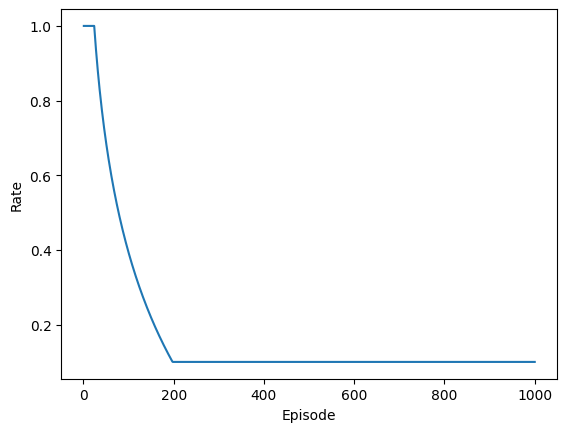

In [3]:
import matplotlib.pyplot as plt
import numpy as np
# Generate sample x points 
x = np.linspace(1, 1000, 1000)
# Get the corresponding rates
y = np.array([get_rate(i) for i in x])
plt.plot(x, y)
plt.xlabel("Episode")
plt.ylabel("Rate")
plt.show()


In [4]:
def update_q(Q_table, state, action, reward, new_state, alpha, gamma):
    Q_table[state][action] = Q_table[state][action] + alpha * (reward + gamma * np.max(Q_table[new_state]) - Q_table[state][action])
    return Q_table

In [5]:
# Install the library very simply through pip 
!pip install gym >/dev/null

# Import the library
import gym

# Create a fresh environment with respect to our carpole game
env = gym.make('CartPole-v0')

# Define the number of episodes for which we want to run (just 1)
for e in range(1):
    # Reset the environment for a new episode, get the default state S_0
    state = env.reset()
    # Define the number of timesteps for which to run the episode by default (200)
    for step in range(200):
        # Sample a random action (A_{t})
        action = env.action_space.sample()
        # Get the new state (S_{t+1}), reward (R_{t+1}), end signal and additional information
        new_state, reward, done, info = env.step(action)
        # Update the state S_{t} = S_{t+1}
        state = new_state
        if done:
            print("Episode finished after {} timesteps".format(step+1))
            break
# Close the environment
env.close()

Episode finished after 19 timesteps


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
# Update the package references repository
!apt update -y >/dev/null
# Install packages for visualisation
!apt-get install xvfb python3-opengl ffmpeg -y >/dev/null
!pip install pyvirtualdisplay imageio >/dev/null

In [7]:
# Do all the necessary imports, based on the installations we just did
import gym, math, imageio, os, time
import numpy as np
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display

# Fix the random number seed
np.random.seed(42)
fake_display = False

In [8]:
# Create a fake display which will help us to render the animations
if fake_display is False:
    display = Display(visible=0, size=(700, 450))
    display.start()
    is_ipython = 'inline' in plt.get_backend()
    if is_ipython:
        from IPython import display
    plt.ion()
    fake_display=True

In [9]:
def Q_learning(env, num_episodes):
    # Discount factor gamma represents how much does the agent value future rewards as opposed to immediate rewards
    gamma = 0.98

    # (1, 1, 6, 12) represents the discretisation buckets
    # Initialise the q-table as full of zeros at the start
    Q_table = np.zeros((1, 1, 6, 12) + (env.action_space.n,))

    # Create a list to store the accumulated reward per each episode
    total_reward = []
    for e in range(num_episodes):
        # Reset the environment for a new episode, get the default state S_0
        state = env.reset()
        state = discretize_state(state, env)

        # Adjust the alpha and the exploration rate, it is a coincidence they are the same
        alpha = exploration_rate = get_rate(e)
        
        # Initialize the current episode reward to 0 
        episode_reward = 0
        done = False
        while done is False:
            # Choose the action A_{t} based on the policy
            action = epsilon_greedy_policy(state, env, Q_table, exploration_rate)

            # Get the new state (S_{t+1}), reward (R_{t+1}), end signal
            new_state, reward, done, _ = env.step(action)
            new_state = discretize_state(new_state, env)

            # Update Q-table via update_q(Q_table, S_{t}, A_{t}, R_{t+1}, S_{t+1}, alpha, gamma) 
            Q_table = update_q(Q_table, state, action, reward, new_state, alpha, gamma)

            # Update the state S_{t} = S_{t+1}
            state = new_state
            
            # Accumulate the reward
            episode_reward += reward
        
        total_reward.append(episode_reward)
    print('Finished training!')
    return Q_table, total_reward

In [10]:
def discretize_state(state, env, buckets=(1, 1, 6, 12)):
    # The upper and the lower bounds for the discretization
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50) / 1.]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50) / 1.]

    # state is the native state representations produced by env
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    # state_ is discretized state representation used for Q-table later
    state_ = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(state))]
    state_ = [min(buckets[i] - 1, max(0, state_[i])) for i in range(len(state))]
    return tuple(state_) 

In [11]:
# OpenAI Gym builds the environment for us inclusing all the rules, dynamics etc.
env = gym.make('CartPole-v0')
# How long do we want the agent to explore and learn
num_episodes = 1000        

# Let us use Q-learning to learn the game!
Q_table, total_reward = Q_learning(env, num_episodes)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Finished training!


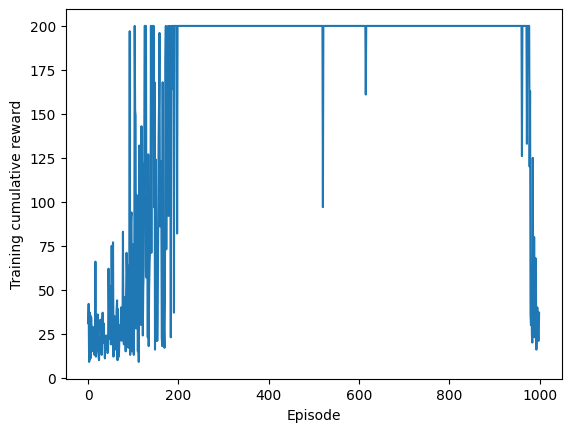

In [12]:
plt.plot(range(num_episodes), total_reward)
plt.xlabel('Episode')
plt.ylabel('Training cumulative reward')
plt.show()

In [13]:
print(Q_table, Q_table.shape)

[[[[[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[27.06134379 30.30853597]
    [17.75625383 28.94006622]
    [ 9.77408919 29.39054817]
    [14.74573383 27.15095068]
    [ 1.41906357 23.3231239 ]
    [ 0.72584215 24.2450257 ]
    [22.12689133  0.        ]
    [28.46838576 15.52225059]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[44.01743016 42.96153131]
    [48.54404876 47.36878756]
    [45.7709702  46.51153581]
    [47.92879691 49.00010997]
    [47.6658418  48.52087584]
    [49.99922384 49.86728053]
    [49.99167168 49.91940465]
    [49.62060302 49.99618088]
    [49.90265468 49.97442278]
    [4

In [14]:
# Initialise the reward
episode_reward = 0

# Count how many times the agent went right and how many times it went left
right = 0
left = 0

# Initialise empty buffer for the images that will be stiched to a gif
# Create a temp directory
filenames = []
try:
    os.mkdir("./temp")
except:
    pass

# Test the trained agent in a completely frest start
state = env.reset()
state = discretize_state(state, env)

# Run for maximum of 200 steps which is the limit of the game
for step in range(200):
    # Plot the previous state and save it as an image that 
    # will be later patched together sa a .gif
    img = plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: {}".format(step))
    plt.axis('off')
    plt.savefig("./temp/{}.png".format(step))
    plt.close()
    filenames.append("./temp/{}.png".format(step))
    
    # Here we set the exploration rate to 0.0 as we want to avoid any random exploration
    action = epsilon_greedy_policy(state, env, Q_table, exploration_rate=0.0)
    right+=1 if action == 1 else 0
    left+=1 if action == 0 else 0
    new_state, reward, done, _ = env.step(action)
    new_state = discretize_state(new_state, env)
    state = new_state
    episode_reward += reward

    # At the end of the episode print the total reward
    if done:
        print(f'Test episode finished at step {step+1} with a total reward of: {episode_reward}')
        print(f'We moved {right} times right and {left} times left')
        break
        
# Stitch the images together to produce a .gif
with imageio.get_writer('test.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup the images for the next run
for f in filenames:
    os.remove(f)

# Close the environment
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


Test episode finished at step 29 with a total reward of: 29.0
We moved 13 times right and 16 times left


<ipython-input-14-7b7238caabd2>:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
